###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2020 Adam Wickenheiser

# Modeling Ideal Gases and Incompressible Liquids

In the previous lesson, we saw how the specific volume of water varies with temperature and pressure.  Notably, there is a large jump in the specific volume when the water transitions from a liquid to a vapor.  This change occurs over a very small temperature range; in fact, the temperature of water is almost constant during the entire boiling process.

In many situations, we want to avoid a phase change because of design constraints.  For example, most pumps and turbines are designed for either a pure liquid or a pure vapor.  A mixture of phases causes wear and tear on these components, leading to early failure.

In this lesson, we will look at two very common approximations to single-phase substances: incompressible liquids and ideal gases.  Using Cantera, which provides exact property values (to within experimental error), we can calculate the accuracy of these approximations.

## Learning objectives:

1. To be able to use incompressible liquid approximations to thermodynamic properties
1. To be able to use curve fits to justify ideal gas approximations
1. To be able to compare ideal and non-ideal gas behaviors and measure discrepancies using the compressibility factor

## Contents:

1. [Incompressible Liquids](#incomp)
1. [Ideal Gases](#idealgas)
1. [Compressibility Factor](#compfact)

<a id='incomp'></a>

### Incompressible Liquids
When we say that a liquid is **incompressible**, we mean that the liquid cannot be compressed mechanically.  This means that no matter how much pressure a liquid is under, its specific volume does not change.  Mathematically, we can write this as

$v(T,p) \approx v(T)$

to indicate that we are approximating specific volume $v$ as a function of temperature $T$ only and ignoring its variation with pressure $p$.

Let's test this theory using Cantera to plot the specific volume of water with respect to temperature and pressure.

First let's import the libraries we will need for this lesson:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct

Let's make two curves, one for water at $T = 60 ^\circ C$ and one for water at $T = 80 ^\circ C$, over a very wide pressure range, let's say $1-20 atm$.

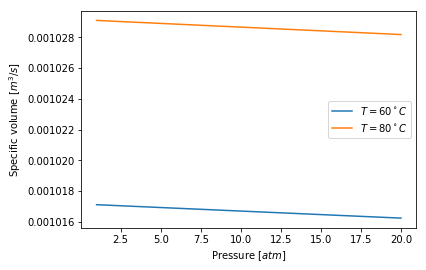

In [2]:
w = ct.Water()                                     # create a 'water' object whose properties we can set and get
T_array = np.array([60, 80]) + 273.15              # convert C to K
P_array = np.arange(1,21,1)*101325.0               # remember that np.range does not include the right endpoint of the range [Pa]
v_array = np.zeros((P_array.size,T_array.size))    # create an array of 0s to store the specific volumes at each temperature

for i in range(P_array.size):
    for j in range(T_array.size):
        w.TP = T_array[j], P_array[i]
        v_array[i,j] = w.v

plt.plot(P_array/101325.0,v_array)
plt.ylabel('Specific volume [$m^3/s$]')
plt.xlabel('Pressure [$atm$]')
plt.legend(['$T = 60 ^\circ C$','$T = 80 ^\circ C$']);

From this plot, we see that these lines very gradually decrease over this pressure range.  We can calculate the relative change for the $T = 60 ^\circ C$ case as follows:

In [3]:
rel_diff_p = (v_array[0,0]-v_array[-1,0])/v_array[-1,0]*100.0
print('Relative difference across pressure range =',rel_diff_p,'%')

Relative difference across pressure range = 0.08577381189154296 %


The average change across the temperature range is

In [4]:
rel_diff_T = np.mean((v_array[:,1]-v_array[:,0])/v_array[:,0]*100.0)
print('Relative difference across pressure range =',rel_diff_T,'%')

Relative difference across pressure range = 1.1755694544029445 %


Let's apply the incompressible liquid approximation to a common device: a water pump!  Almost all thermodynamic systems have some kind of pump or gas compressor... in this case let's look at the water pumps in a nuclear power plant.

**Example:** A nuclear power plant produces $120 MW$ of electricity.  The pump in the vapor power cycle pumps liquid water from $P_1 = 10 kPa$ to $P_2 = 10 MPa$.  Assume the water enters the pump as a saturated liquid and flows at a rate of $\dot{m} = 170 kg/s$.  Estimate how much power is required by the pump assuming the liquid water is incompressible.

Assume the following equation for the pump power (we will derive this later!):

$P_{pump} = \dot{m}v(P_2 - P_1)$

The following diagram labels the inlet (1) and the outlet (2) of the pump in the cycle.

<img src="https://github.com/AdaWick/CDS/blob/master/Thermodynamics/images/incompressible liquid pump ex.png?raw=true" width="500">

Let's summarize what we know about the inlet (state 1) and outlet (state 2):

**State 1:**  ***Known:*** $P_1,x_1$, ***Unknown:*** $v_1$

**State 2:**  ***Known:*** $P_2,v_2$ (once we find $v_1$, we can assume $v_2 = v_1$ by incompressibility)

$P_1$ and $P_2$ are given to us directly in the problem statement.  $x_1$, the quality of the water, is also given, although it is hidden!  The problem states that the water enters the pump as a *saturated liquid*; therefore, we can set $x_1 = 0$.  This means the water is 100% liquid, $x_1 = 1$ would indicate 100% vapor, and values in-between indicate a liquid-vapor mixture.

This means we have enough information to find the pump power:

In [5]:
# state 1
P1 = 10.0e3            # pressure [Pa]
x1 = 0.0               # quality
state1 = ct.Water()    # create water object
state1.PX = P1, x1     # set pressure and quality
v1 = state1.v          # specific volume [m^3/kg]

# state 2
v2 = v1                # specific volume [m^3/kg]
P2 = 10.0e6            # pressure [Pa]
state2 = ct.Water()    # create water object
state2.PV = P2, v2     # set pressure and specific volume

# compute pump power
mdot = 170                 # mass flow rate [kg/s]
P_pump = mdot*v1*(P2-P1)   # pump power [W]
print('Pump power =',P_pump/1e6,'MW')

Pump power = 1.7157336876099587 MW


We can see that about $\dfrac{1.72 MW}{120 MW} \times 100\% = 1.4\%$ of the power plant's output is used to run the pump.  This ratio is known as the **back work ratio**.  We will see later that in order to keep this ratio small, water should be pumped as a liquid, and power should be extracted from it as a vapor (using a turbine).

Now, let's plot this process along with the vapor dome for water.  We will make use of some functions given in the previous lesson.

In [6]:
def Tv_vapor_dome():
    
    w = ct.Water()
    
    # critical temperature and specific volume
    Tcrit = w.critical_temperature    # critical temperature [K]
    vcrit = 1/w.critical_density      # critical specific volume [m^3/kg]

    # set up arrays for plotting saturated curves
    T_array = np.linspace(15+273.15,0.9999*Tcrit)   # the temperature range must stop just before the critical point
    vf_array = np.zeros_like(T_array)
    vg_array = np.zeros_like(T_array)

    # get saturated states for plotting
    for i in range(T_array.size):
        w.TX = T_array[i], 0        # saturated liquid (x = 0)
        vf_array[i] = w.v
    
        w.TX = T_array[i], 1        # saturated vapor (x = 1)
        vg_array[i] = w.v

    # plot saturated curves and critical point
    plt.semilogx(vf_array,T_array-273.15,'g',vg_array,T_array-273.15,'g',vcrit,Tcrit-273.15,'r*')
    plt.ylabel('Temperature [$^\circ C$]')
    plt.xlabel('Specific volume [$m^3/s$]')

In [7]:
def Tv_diagram(*args):
    
    T_states = np.zeros(len(args),)  # array to store temperatures at each state
    v_states = np.zeros(len(args),)  # array to store specific volumes at each state
    
    for i in range(len(args)):       # loop through each state in the process
        T_states[i] = args[i].T
        v_states[i] = args[i].v
        plt.text(v_states[i],T_states[i]-273.15,'  '+str(i+1),fontsize=12)
    plt.semilogx(v_states,T_states-273.15,'bo-',linewidth=2)   

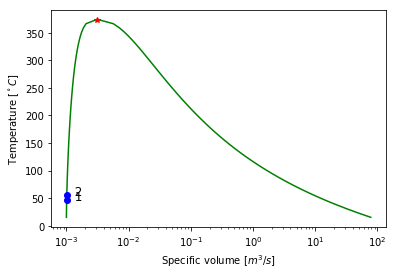

In [8]:
Tv_vapor_dome()
Tv_diagram(state1,state2)

We can see from this diagram that even though the pressure increases by a factor of 1000, this did not cause much change on the T-v diagram.  This reinforces the fact that compressing a liquid does not change its thermodynamic state by much.

Let's zoom in on this plot to see the pump process better:

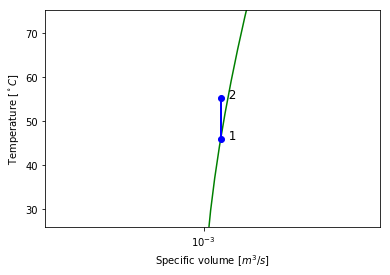

In [9]:
Tv_vapor_dome()
Tv_diagram(state1,state2)

# zoom in
plt.axis([0.9*v1, 1.1*v1, state1.T-20-273.15, state2.T+20-273.15]);

Now, we can see that the water starts as a *saturated liquid* at the inlet (it's on the green saturated liquid curve), then it becomes a *compressed liquid* at the outlet (it's to the left of the green saturated liquid curve).

#### Try it!

Add isobars for $P_1$ and $P_2$ to the zoomed-out plot of the vapor dome and the pump process.

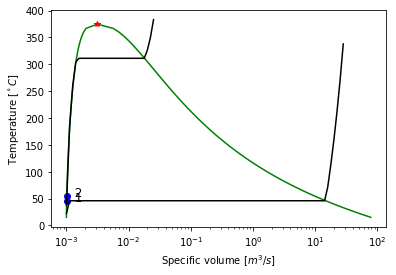

In [10]:
Tv_vapor_dome()
Tv_diagram(state1,state2)

w = ct.Water()
v_array = np.logspace(-2.999,2,101)

# plot isobar through state 1
T_array = np.full_like(v_array,np.nan)
for i in range(v_array.size):
    w.PV = state1.P, v_array[i]
    if w.T > 400 + 273.15:
        break
    T_array[i] = w.T
plt.semilogx(v_array,T_array-273.15,'k')

# plot isobar through state 2
T_array = np.full_like(v_array,np.nan)
for i in range(v_array.size):
    w.PV = state2.P, v_array[i]
    if w.T > 400 + 273.15:
        break
    T_array[i] = w.T
plt.semilogx(v_array,T_array-273.15,'k');

<a id='idealgas'></a>

### Ideal Gases

You may remember from Chemistry class two laws that closely approximate the behavior of most gases at reasonable temperatures and pressures. These are [Charles' Law](https://en.wikipedia.org/wiki/Charles%27s_law) and [Boyle's Law](https://en.wikipedia.org/wiki/Boyle%27s_law).

**Charles' Law** states that as a fixed amount of gas is heated under constant pressure, its volume and its temperature remain in proportion.  This is just a fancy way of saying, "If the temperature is doubled, then the volume of the gas will also double".  One thing we should note immediately is that this only works for *absolute temperature scales* (the volume of a gas under constant pressure will only shrink to 0 when the temperature approaches absolute zero).

We can write this law mathematically as: $v = kT$, where $k$ is a constant.

It makes sense that as you heat a gas, it should expand: as it gets hotter it has more "internal energy" (we'll define this later) to push against its surroundings.  But is the expansion really linear with temperature increase?

Let's demonstrate Charles' Law using a familiar gas: carbon dioxide ($CO_2$).  Carbon dioxide is a gas at most temperatures and pressures you will encounter in Thermodynamics applications.

Let's see what happens when we vary the temperature of $CO_2$ while keeping pressure constant for a few different values of pressure.

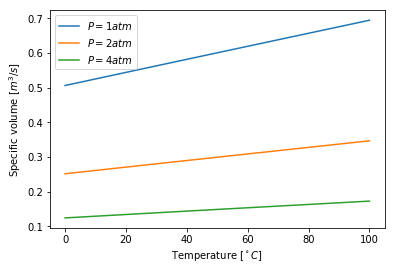

In [11]:
c = ct.CarbonDioxide()                            # create a CO2 object whose properties we can set and get
P_array = np.array([1, 2, 4])*101325.0            # pressure [Pa]
T_array = np.arange(0,101,10) + 273.15            # remember that np.range does not include the right endpoint of the range [K]
v_array = np.zeros((T_array.size,P_array.size))   # create an array of 0s to store the specific volumes

for i in range(T_array.size):
    for j in range(P_array.size):
        c.TP = T_array[i], P_array[j]
        v_array[i,j] = c.v

plt.plot(T_array - 273.15,v_array)
plt.ylabel('Specific volume [$m^3/s$]')
plt.xlabel('Temperature [$^\circ C$]')
plt.legend(['$P = 1 atm$','$P = 2 atm$','$P = 4 atm$']);

This is a great opportunity to perform a linear fit of this data (also known as linear regression).  Let's find out how straight these lines actually are!

First we must add the library for the function we'll want to use [scipy.stats.linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html).  We will apply this function to the $P = 1 atm$ data set.

In [12]:
import scipy.stats as stats

R^2 value = 0.9999984060005197


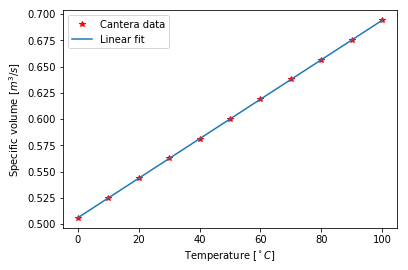

In [13]:
# replot the P=1 atm data as red stars
plt.plot(T_array - 273.15,v_array[:,0],'r*')
plt.ylabel('Specific volume [$m^3/s$]')
plt.xlabel('Temperature [$^\circ C$]')

# perform linear regression
out = stats.linregress(T_array - 273.15,v_array[:,0])
T_array_dense = np.arange(0,101,1) + 273.15        # make a denser T_array for plotting the curve fit
plt.plot(T_array_dense - 273.15,out.slope*(T_array_dense - 273.15) + out.intercept)
plt.legend(['Cantera data','Linear fit'])
print('R^2 value =',out.rvalue**2)

Wow!  Most people would kill for an $R^2$ value that close to 1.

This plot should convince you that Charles' Law is a good approximation to $CO_2$'s behavior under normal conditions.

**Boyle's Law** states that as a fixed amount of gas is compressed under constant temperature, its volume decreases inversely with pressure.

We can write this law mathematically as: $Pv = k$, where $k$ is a constant.

It makes sense that as you apply more pressure to a gas, it should shrink in volume.  But is the compression really inversely proportional to the pressure?

Let's see what happens when we vary the pressure of $CO_2$ while keeping temperature constant for a few different values of temperature.

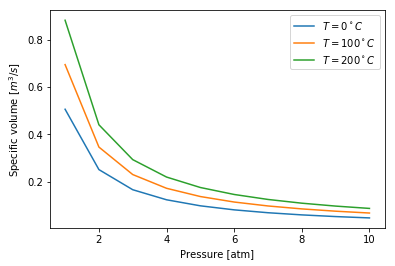

In [14]:
c = ct.CarbonDioxide()                            # create a CO2 object whose properties we can set and get
T_array = np.array([0, 100, 200]) + 273.15        # temperature [K]
P_array = np.arange(1,11,1)*101325.0              # remember that np.range does not include the right endpoint of the range [Pa]
v_array = np.zeros((P_array.size,T_array.size))   # create an array of 0s to store the specific volumes

for i in range(P_array.size):
    for j in range(T_array.size):
        c.TP = T_array[j], P_array[i]
        v_array[i,j] = c.v

plt.plot(P_array/101325.0,v_array)
plt.ylabel('Specific volume [$m^3/s$]')
plt.xlabel('Pressure [atm]')
plt.legend(['$T = 0 ^\circ C$','$T = 100 ^\circ C$','$T = 200 ^\circ C$']);

Indeed, these curves do look like a family of inverse relations, i.e. $y = \frac{k}{x}$, where $k$ is a constant.  But let's find out how close the real behavior is modeled by these relations.

Since we are attempting to fit the data to a nonlinear function, we can no longer use the `stats.linregress` function, which is only for linear fitting.  Instead, we will use [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit), which can attempt to fit any function you can write an equation for.  The fit function we give it has to be of the form $y = f(x,p_1,p_2,...)$, where $p_1,p_2,...$ are unknown parameters (constants) of the function.  The algorith tries to find the values of these parameters that best fit the data.

In our case, we can write $y = \frac{p_1}{x}$, where $y = v$ (specific volume, the dependent variable), $x = P$ (pressure, the independent variable), and $p_1 = k$, the unknown constant.

In [15]:
import scipy.optimize as optim

Standard error = [0.00204012]


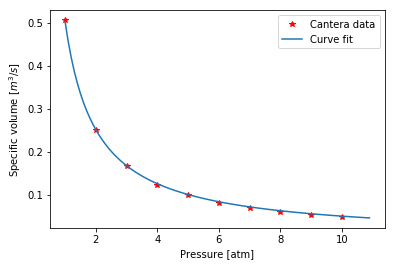

In [16]:
# replot the P=1 atm data as red stars
plt.plot(P_array/101325.0,v_array[:,0],'r*')
plt.ylabel('Specific volume [$m^3/s$]')
plt.xlabel('Pressure [atm]')

# define a function to fit
def func(x, k):
    return k/x

# perform nonlinear curve fit
popt,pcov = optim.curve_fit(func,P_array/101325.0,v_array[:,0])
P_array_dense = np.arange(1,11,0.1)*101325.0            # make a denser P_array for plotting the curve fit
plt.plot(P_array_dense/101325.0,func(P_array_dense/101325.0,popt))
plt.legend(['Cantera data','Curve fit'])
print('Standard error =',np.sqrt(np.diag(pcov)))

While there is no $R^2$ value for nonlinear regression, the standard error measures the standard deviation of the data about the curve fit (so, smaller is better!) and can be used to compute confidence intervals.

We can combine Charles' and Boyle's Laws to arrive at the following relation:

$\dfrac{Pv}{T} = const.$

Typically, this equation is rearranged in the form

$Pv = RT$

where $R$ is called the **(specific) gas constant**.  Each gas -- like carbon dioxide, oxygen, nitrogen, and air -- has a different value of $R$ because their constituent particles have different masses.  (Heavier particles exert more pressure on the walls of a container, all other parameters being equal.)

Remembering the definition of specific volume, $v = \frac{V}{m}$, we can rewrite the previous equation as

$PV = mRT$

In some cases, it's easier to work with this equation on a per-mole basis instead of a per-mass basis.  Suppose there are $n$ moles of the gas.  Then we can define the **molar mass** as $M = \frac{m}{n}$, which is usually given in units of grams-per-mole or, equivalently, kilograms-per-kilomole.

Thus, we can rewrite this equation on a per-mole basis:

$PV = nMRT = n\bar{R}T$

where $\bar{R} = MR$ is the **universal gas constant**, which is the same for all gases.

Finally, let's define $\bar{v}$ to be the volume of one mole of gas.  Then we get

$P\bar{v} = \bar{R}T$

Each of these equations is a different form of the **ideal gas law**.  Although we use the word "law", this equation is an approximation to actual gas behavior (although we've seen that it is a really good approximation for certain gases under certain conditions!).  This law can also be derived from the kinetic theory of gases, but this route also requires making a lot of approximations.

<a id='compfact'></a>

### Compressibility Factor

We expect that as a gas approaches its saturated vapor curve and begins to condense to a liquid or solid, its behavior should deviate greatly from ideal gas behavior.  We saw in the previous lesson that when steam condenses to liquid water, its volume decreases by a factor of 1000 with hardly any change in temperature or pressure.  This phase-change behavior deviates greatly from both Charles' and Boyle's Laws, which predict gradual changes in specific volume as temperature and/or pressure are varied.

To measure how close a real gas is to an ideal gas, let's define a new quantity $Z$, called the **compressibility factor**:

$Z = \dfrac{Pv}{RT}$

Comparing this equation to the ideal gas law shows that and ideal gas should have $Z = 1$.  We can then say that as $Z$ deviates further and further from $1$, the behavior of the gas deviates further and further from ideal.

Let's take a look at how water vapor/steam compares to the ideal gas behavior.  We should expect that as the water starts to condense to liquid, it will diverge from the ideal gas equation, so we should see $Z$ diverge away from $1$.

To visualize this, we will plot countors of $Z$ on the same T-v axis as the vapor dome.  Let's see how $Z$ changes as we get closer to the vapor dome.

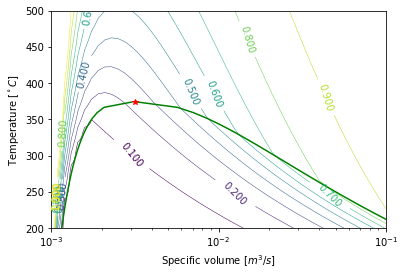

In [17]:
Tv_vapor_dome()

w = ct.Water()
Rbar = ct.gas_constant       # universal gas constant [J/(kmol*K)]
M = w.mean_molecular_weight  # molar mass [kg/kmol]
R = Rbar/M                   # specific gas constant for water [J/(kg*K)]

v_min = 1e-3       # minimum specific volume [m^3/kg]
v_max = 1e-1        # maximum specific volume [m^3/kg]
T_min = 200        # minimum temperature [C]
T_max = 500        # maximum temperature [C]

v_array = np.geomspace(v_min,v_max,51)           # logspace from v_min to v_max [m^3/kg]
T_array = np.linspace(T_min,T_max,101) + 273.15   # linspace from T_min to T_max [K]
Z_array = np.zeros((T_array.size,v_array.size))   # create an array of 0s to store the compressibility factors

for i in range(T_array.size):
    for j in range(v_array.size):
        w.TV = T_array[i], v_array[j]
        Z_array[i,j] = (w.P*v_array[j])/(R*T_array[i])
        
levels = plt.contour(v_array,T_array - 273.15,Z_array,np.arange(0.1,1.1,0.1),linewidths=0.5)
plt.gca().clabel(levels,inline_spacing=-4)
plt.axis([v_min, v_max, T_min, T_max]);

Let's look at the same situation for carbon dioxide, which we've already seen behaves like an ideal gas under reasonable atmospheric conditions.  But what do we mean by "reasonable"?  Is there a quick way we can determine if the ideal gas law is accurate enough to use in design?

Examinging the previous figure, we can see that $Z \to 1$ as we move up and to the right of the critical point (the red star).  Near this point, the distinction between liquids and gases is blurred -- definitely not the behavior of an ideal gas!

Let $T_c$ and $P_c$ be the temperature and pressure of the critical point, respectively.  Then we can make the following observations:

1. If $P \ll P_c$, then the specific volume will be much larger than the critical point's and so the gas can be assumed to be ideal
1. If $T > 2 T_c$, then the substance, which is considered to be **supercritical**, also acts like an ideal gas, unless $P \gg P_c$, in which case it behaves more like a liquid
1. If $T \approx T_c$ and $P \approx P_c$, then the substance is near its critical point and does not behave ideally

Let's compare the cricial points of carbon dioxide and water:

In [18]:
w = ct.Water()
print('Water:')
print('Critical temperature =',w.critical_temperature - 273.15,'C')
print('Critical pressure =',w.critical_pressure/101325.0,'atm')

c = ct.CarbonDioxide()
print('Carbon dioxide:')
print('Critical temperature =',c.critical_temperature - 273.15,'C')
print('Critical pressure =',c.critical_pressure/101325.0,'atm')

Water:
Critical temperature = 374.13599999999997 C
Critical pressure = 218.00148038490008 atm
Carbon dioxide:
Critical temperature = 31.060000000000002 C
Critical pressure = 72.8694793979768 atm


If our application is at temperatures above the critical temperature, then we don't have to worry about phase change, and we need only check that the pressure is not small compared to the critical pressure.

At lower temperatures, we need to make sure we are using pressures well above the saturation pressure at that temperature (when liquid condensation occurs).  On the T-v diagram, this just means we are far enough to the right of the saturated vapor curve.

Let's see if we can apply the ideal gas law to the steam turbine in the nuclear power plant cycle we looked at before.

**Example:** As given in the previous example, the pump in the vapor power cycle pumps liquid water from $P_1 = 10 kPa$ to $P_2 = 10 MPa$.  The boiler and condenser operate at constant pressure, so we can assume $P_3 = P_2$ and $P_4 = P_1$, referring to the following diagram:

<img src="https://github.com/AdaWick/CDS/blob/master/Thermodynamics/images/ideal gas turbine ex.png?raw=true" width="500">

Furthermore, we are told that the boiler heats the steam to a temperature of $T_3 = 350 ^\circ C$.

Let's summarize what we know about the inlet (state 1) and outlet (state 2):

**State 1:**  ***Known:*** $P_1,x_1$, ***Unknown:*** $v_1$

**State 2:**  ***Known:*** $P_2,v_2$ (once we find $v_1$, we can assume $v_2 = v_1$ by incompressibility)

$P_1$ and $P_2$ are given to us directly in the problem statement.  $x_1$, the quality of the water, is also given, although it is hidden!  The problem states that the water enters the pump as a *saturated liquid*; therefore, we can set $x_1 = 0$.  This means the water is 100% liquid, $x_1 = 1$ would indicate 100% vapor, and values in-between indicate a liquid-vapor mixture.

This means we have enough information to find the pump power:

State 3 compressibility factor = 0.9188680169402386
State 4 compressibility factor = 0.6792500288698078


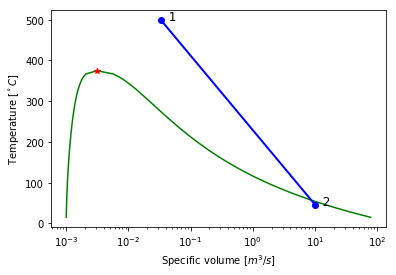

In [19]:
# state 3
P3 = 10.0e6            # pressure [Pa]
T3 = 500 + 273.15      # temperature [K]
state3 = ct.Water()    # create water object
state3.TP = T3, P3     # set temperature and pressure
v3 = state3.v          # specific volume [m^3/kg]

# state 4
v4 = 10                # specific volume [m^3/kg]
P4 = 10.0e3            # pressure [Pa]
state4 = ct.Water()    # create water object
state4.PV = P4, v4     # set pressure and specific volume
T4 = state4.T          # temperature [K]

Tv_vapor_dome()
Tv_diagram(state3,state4)

# compute compressibility factor at each state
Z3 = (P3*v3)/(R*T3)
Z4 = (P4*v4)/(R*T4)
print('State 3 compressibility factor =',Z3)
print('State 4 compressibility factor =',Z4)

These results indicate that at state 3 (the turbine inlet), the water vapor (steam) acts more like an ideal gas ($Z_3 = 0.92$) than at state 4 (the turbine outlet), where $Z_4 = 0.68$ and, in fact, some of the steam has already condensed to liquid.  This can be visualized on the T-v diagram.  State 3 (labeled "1" on the diagram) is above and to the right of the critical point, where ideal gas behavior is found.  State 4 (labeled "4" on the diagram) is below the saturated vapor curve, and so it is a mixed liquid-vapor at this point.  As we stated previously, a phase change is a huge departure from ideal gas behavior, so it's no surprise that $Z_4 < Z_3$ in this situation.

We will see later that when we design turbines, we want the pressure drop to be as large as possible to extract the most energy from the steam.  However, the more we drop the outlet pressure, the more vapor begins to condense to liquid.  This has the nasty side-effect of damaging the turbine blades!